# 1. Data collection

We have to build a search engine over the "Top Anime Series" from the list of MyAnimeList.net. Let's start creating our dataset.

## 1.1 Get the list of animes

First of all we need to get the url of the anime that will appear in our list. In order to do that we use BeautifulSoup in combination with the requests library. 

In [10]:
#importing library needed
import numpy as np
import pandas as pd 
import requests
import time
import csv
import os
import ast
from bs4 import BeautifulSoup as bs
from datetime import datetime as dt
from nltk.stem import PorterStemmer

In [2]:
#we define a function that from the given url of the main page, using BigSoup, gather all the urls 
#of the animes by filtering the headers of the page. We use start and stop to set the number of pages
#we want to have
def getUrls(start, stop): 

    urls = []
    for i in range(start, stop):
        url = 'https://myanimelist.net/topanime.php?limit='+str(i*50)
        r = requests.get(url)
        html_content = r.text
        soup = bs(html_content, 'lxml')
        links = soup.find_all('h3') 

        for anime in links[:-3]:
            if anime.find('a'):
                urls.append(anime.find('a')['href'])
    return urls

Once we have a list containing all the URLs, we write them in a text file, so we can avoid this step for the next few times.

In [ ]:
#saving all the urls in a text file
f = open("topAnime.txt", 'w', encoding="utf8")
f.write('\n'.join(getUrls(0,400)))
f.close

## 1.2 Crawl animes

Now that we get all the urls, we need to "convert" them in html files, so we use the request library to download and save all the anime html pages.

In [3]:
# This function take in input the page number, it will then go into the file previously created and, 
#using the urls of each anime, download the html file corresponding to each of them. 
# We store the files in subdirectory ordered by the page they appear in, by chunks of 50.
def saveHtml(page):
#saving the HTML file of page 'page' in the corresponding folder
    #creating a subfolder to store the html file of the page 'page'
    subfolder = "downloaded_Html/page_{}".format(page)
    os.makedirs(subfolder)

    f = open("topAnime.txt", 'r', encoding="utf8")
    lines = f.readlines()[(page-1)*50:(page)*50]
    lines = [line.rstrip() for line in lines]
    f.close

    i = 1+50*(page-1)
    #for each link that we read let's create a new .html file
    for link in lines:
        html = requests.get(link)
        
        if html.status_code != 200:
            while(html.status_code != 200): 
                check = requests.get(link)
        
        file_name = '{}/{}.html'.format(subfolder, i)
        g = open(file_name, 'w', encoding="utf8")
        g.write(html.text)
        g.close
        i += 1

In [ ]:
for i in range(400):
    saveHtml(i)

## 1.3 Parse downloaded pages

We are getting closer to our dataset! Now that we've downloaded all the anime pages needed, we can extrapolate the features to create our dataset. In the next cell we define some functions useful to obtain each feature.

In [5]:
##title
def getTitle(anime):
    return anime.strong.contents[0]

#type
def getType(anime):
    return anime.find(text = 'Type:').find_next('a').contents[0]

#num episodes
def getNumEpis(anime):
    if anime.find(text = 'Episodes:').next_element.strip() != "Unknown":
        return int(anime.find(text = 'Episodes:').next_element.strip())
    else :
        return []

#starting date    
def getStart(anime):
    date = anime.find(text = 'Aired:').next_element.strip()
    
    if date != "Not available":
        if len(date.split(" to ")[0]) > 8:
            return dt.strptime(date.split(" to ")[0], '%b %d, %Y' )
        elif len(date.split(" to ")[0]) == 4:
            return dt.strptime(date.split(" to ")[0], '%Y' )
        elif len(date.split(" to ")[0]) == 8:
            return dt.strptime(date.split(" to ")[0], '%b %Y' )
        else:
            return pd.to_datetime(np.NaN, errors='coerce')
    else :
        return []

#ending date   
def getEnd(anime):
    date = anime.find(text = 'Aired:').next_element.strip()
    
    if date != "Not available":
        if len(date)>12 and len(date.split(" to ")[1]) > 8 and date.split(" to ")[1] != "?":
            return dt.strptime(date.split(" to ")[1], '%b %d, %Y' )
        elif len(date)>12 and len(date.split(" to ")[1]) == 4 and date.split(" to ")[1] != "?":
            return dt.strptime(date.split(" to ")[1], '%Y' )
        elif len(date)>12 and len(date.split(" to ")[1]) == 8 and date.split(" to ")[1] != "?":
            return dt.strptime(date.split(" to ")[1], '%b %Y' )
        else:
            return pd.to_datetime(np.NaN, errors='coerce')
    else :
        return []        

#members number   
def getNumMemb(anime):
    animeNumMembers = anime.find(text = 'Members:').next_element
    return int(animeNumMembers.replace('n', '').replace(',', '').strip())

#score of the anime
def getScore(anime):
    if anime.find(text = 'Score:').find_next('span').contents[0] != 'N/A':
        animeScore = anime.find(text = 'Score:').find_next('span').contents
        return float(animeScore[0])
    else :
        return []         

#user votiing    
def getUsers(anime):
    animeUsers = anime.find(text = 'Score:').find_next('span').find_next('span').contents
    if animeUsers[0] != 'Ranked:':
        return int(animeUsers[0])
    else :
        return []      

#anime rank
def getRank(anime):
    animeRank = anime.find(text = 'Ranked:').next_element
    if animeRank.replace('\n', '').strip() != 'N/A':
        return int(animeRank.replace('\n', '').replace('#', '').strip())
    else :
        return [] 

#anime Popularity   
def getPopularity(anime):
    animePopularity = anime.find(text='Popularity:').next_element
    return int(animePopularity.replace("\n","").replace('#', '').strip())

#anime description
def getDescription(anime):
    animeDescription = anime.find(text = 'Synopsis').find_next('p').text
    return animeDescription.replace("\n","")

#related anime
def getRelated(anime):
    table = anime.find(text = 'Related Anime')
    animeRelated = []

    if(table != None):    
        table = table.find_next('table')
        table = table.find_all('a')

        for el in table:
            animeRelated.append(el.text)
                
    return animeRelated

#get the name of the main characters
def getCharact(anime):
    table = anime.find(text = 'Characters & Voice Actors').find_next('div')
    table = table.find_all('table')

    animeChar = []

    for el in table:
        people = el.find_all('h3')
        for person in people:
            animeChar.append(person.text)
        
    return animeChar

#get the voices of the main characters
def getVoices(anime):
    table = anime.find(text = 'Characters & Voice Actors').find_next('div')
    table = table.find_all('h3')

    animeVoices = []

    for el in table:
        people = el.find_next('table')
        for person in people:
            animeVoices.append(person.find('a').text)
        
    return animeVoices

#get name and role of the staff
def getStaff(anime):
    
    table = anime.find_all(text = 'Staff')[1].find_next("div", {"class": "detail-characters-list clearfix"})
    animeStaff = []
    if(table != None):    
        table = table.find_all("table")
        for el in table:
            x = el.find_all("td")[1]
            person = [x.find("a").text, x.find("small").text]
            animeStaff.append(person)
    
    return animeStaff

In [6]:
#since the pages are not saved in numerical order in the folder, let’s tidy them up
pages = sorted(os.listdir('downloaded_Html')[1:], key = lambda page : int(page.split("_")[1]))

title = []
typ = []
numEpisode = []
start = []
end = []
numMembers = []
score = []
users = []
rank = []
popularity = []
synopsis = []
related = []
char = []
voices = []
staff = []

In [ ]:
#let's extrapolate the features from each anime and store them in lists
for page in pages:
    htmls = os.listdir('downloaded_Html/{}'.format(page))
    for i in range(1,1+len(htmls)):
        f = open("downloaded_Html/{}/{}.html".format(page,50*(int(page.split("_")[1])-1)+i), 'r', encoding="utf8")
        anime = bs(f, 'lxml')
        title.append(getTitle(anime))
        typ.append(getType(anime))
        numEpisode.append(getNumEpis(anime))
        start.append(getStart(anime))
        end.append(getEnd(anime))
        numMembers.append(getNumMemb(anime))
        score.append(getScore(anime))
        users.append(getUsers(anime))
        rank.append(getRank(anime))
        popularity.append(getPopularity(anime))
        synopsis.append(getDescription(anime))
        related.append(getRelated(anime))
        char.append(getCharact(anime))
        voices.append(getVoices(anime))
        staff.append(getStaff(anime))

In [ ]:
col = ['animeTitle', 'animeType', 'animeNumEpisode','releaseDate', 'endDate', 'animeNumMembers', 'animeScore', 'animeUsers', 
       'animeRank', 'animePopularity', 'animeDescription', 'animeRelated', 'animeCharacters', 'animeVoices', 'animeStaff']

types = {'animeTitle' : 'object', 
         'animeType' : 'object', 
         'animeNumEpisode' : 'int64',
         'releaseDate' : 'datetime64', 
         'endDate' : 'datetime64', 
         'animeNumMembers' : 'int64', 
         'animeScore' : 'float64',
         'animeUsers' : 'int64', 
         'animeRank' : 'int64',
         'animePopularity' : 'int64',
         'animeDescription' : 'object',
         'animeRelated' : 'object',
         'animeCharacters' : 'object',
         'animeVoices' : 'object',
         'animeStaff' : 'object'}

df = pd.DataFrame(columns = col).astype(dtype = types) 

df.animeTitle = title 
df.animeType = typ 
df.animeNumEpisode = numEpisode 
df.releaseDate = start 
df.endDate = end 
df.animeNumMembers = numMembers 
df.animeScore = score 
df.animeUsers = users 
df.animeRank = rank 
df.animePopularity = popularity 
df.animeDescription = synopsis 
df.animeRelated = related 
df.animeCharacters = char 
df.animeVoices = voices 
df.animeStaff = staff 

Finally here it is, we got our dataset!

In [ ]:
# We create a .tsv file (tab separated values) where we are going to store all of the informations 
# for each anime
df = df.to_csv("data/anime.tsv", sep='\t', index=False)

In [68]:
df = pd.read_csv("data/anime.tsv", sep='\t')
df.head()

,animeTitle,animeType,animeNumEpisode,releaseDate,endDate,animeNumMembers,animeScore,animeUsers,animeRank,animePopularity,animeDescription,animeRelated,animeCharacters,animeVoices,animeStaff
0,Fullmetal Alchemist: Brotherhood,TV,64,2009-04-05 00:00:00,2010-07-04 00:00:00,2677887,9.16,1629051,1,3,After a horrific alchemy experiment goes wrong...,"['Fullmetal Alchemist', 'Fullmetal Alchemist',...","['Elric, Edward', 'Elric, Alphonse', 'Mustang,...","['Park, Romi', 'Kugimiya, Rie', 'Miki, Shinich...","[['Cook, Justin', 'Producer'], ['Yonai, Norito..."
1,Gintama°,TV,51,2015-04-08 00:00:00,2016-03-30 00:00:00,484270,9.09,169476,2,337,"Gintoki, Shinpachi, and Kagura return as the f...","['Gintama', 'Gintama Movie 2: Kanketsu-hen - Y...","['Sakata, Gintoki', 'Kagura', 'Shimura, Shinpa...","['Sugita, Tomokazu', 'Kugimiya, Rie', 'Sakaguc...","[['Fujita, Youichi', 'Director, Storyboard, Pl..."
2,Shingeki no Kyojin Season 3 Part 2,TV,10,2019-04-29 00:00:00,2019-07-01 00:00:00,1598256,9.09,1087519,3,33,Seeking to restore humanity's diminishing hope...,"['Shingeki no Kyojin', 'Shingeki no Kyojin Sea...","['Levi', 'Yeager, Eren', 'Ackerman, Mikasa', '...","['Kamiya, Hiroshi', 'Kaji, Yuki', 'Ishikawa, Y...","[['Yabuta, Shuuhei', 'Producer'], ['Wada, Jouj..."
3,Steins;Gate,TV,24,2011-04-06 00:00:00,2011-09-14 00:00:00,2092380,9.09,1115839,4,11,The self-proclaimed mad scientist Rintarou Oka...,"['Steins;Gate', 'ChäoS;HEAd', 'Robotics;Notes'...","['Okabe, Rintarou', 'Makise, Kurisu', 'Shiina,...","['Miyano, Mamoru', 'Imai, Asami', 'Hanazawa, K...","[['Iwasa, Gaku', 'Producer'], ['Yasuda, Takesh..."
4,Fruits Basket: The Final,TV,13,2021-04-06 00:00:00,2021-06-29 00:00:00,275939,9.07,113310,5,653,"Hundreds of years ago, the Chinese Zodiac spir...","['Fruits Basket', 'Fruits Basket 2nd Season', ...","['Souma, Kyou', 'Honda, Tooru', 'Souma, Yuki',...","['Uchida, Yuuma', 'Iwami, Manaka', 'Shimazaki,...","[['Ibata, Yoshihide', 'Director'], ['Aketagawa..."


# 2. Search engine

### Preprocessing Anime Descriptions

In this section we preprocess the Synopsis of the Anime with the following steps:

- Stopwords and punctuation removal
- Case normalization (we chose to convert everything to lower case)
- Lemmatization, i.e., an alternative to Stemming based on *Part-Of-Speech tagging* and a dictionary (english in our case). We preferred it over Stemming because it returns proper words that have a meaning in english rather then cut off portions of those words
- Tokenization of text

In [288]:
#Import Libraries
import nltk
from nltk.corpus import wordnet
from os.path import expanduser
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\CASA-PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\CASA-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\CASA-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\CASA-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [289]:
#Part Of Speech Tagging Step needed for Lemmatization
def wordnet_pos_gen(lista): 
    pos_tags = list(nltk.pos_tag(lista))
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    t = []
    for x in pos_tags:
        try:
            t.append((x[0], tag_dict[x[1][0]]))
        except Exception:
            t.append(
                (x[0], "n"))
    return t

In [290]:
# Stopwords Removal
def stopping(ls, *args):
    processed = []
    for case in ls:
        tok = word_tokenize(case)
        stop_words = set(stopwords.words("english"))
        stop_words.add(","), stop_words.add("."), stop_words.add(";"), stop_words.add(":")
        res = [x for x in tok if not x in stop_words]
        result = ""
        for x in res:
            result = result + " " + x
        processed.append(result)
    return processed

In [291]:
# Lemmatizer
def lemma(lista):
    out = []
    t = wordnet_pos_gen(lista)
    lemmatizer = WordNetLemmatizer()
    res = [lemmatizer.lemmatize(w[0], w[1]) for w in t]
    result = ""
    for x in res:
        result = result + " " + x
    out.append(result.lower())  #case normalization step here
    return out

In [292]:
#Tokenization of preprocessed anime descriptions
descr_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')

df = pd.read_csv("data/anime.tsv", sep='\t')

for descr in df.animeDescription:
    tokenized_descr = tokenizer.tokenize(descr.lower())
    descr_corpus_tokenized.append(tokenized_descr)

for s,descr in enumerate(descr_corpus_tokenized):
    filtered = []
    for token in descr:
        if len(token) > 2 and not token.isnumeric():
            filtered.append(token)
    descr_corpus_tokenized[s] = filtered

In [293]:
pd.options.mode.chained_assignment = None
#Create a new column with the preprocessed text, since we will output the original version    
df["animeDescr"] = pd.Series('object')

#Assign the new description to each new row as a list
for y in range(len(df.animeDescription)):
    df.animeDescr[y] = [x for x in stopping(lemma(descr_corpus_tokenized[y])) if x != ""]

#Convert lists into strings for each row     
for x in range(len(df.animeDescr)):
    s = ""
    for y in df.animeDescr[x]:
        s+=y
    df.animeDescr[x] = s

## 2.1 Conjunctive query

In [59]:
# Now that we have all the information we need, well stored, we need to start the preprocessing part.
synopsis = pd.read_csv("data/anime.tsv", sep='\t', usecols = ["animeDescription"])

# Using nltk library we gather all the stopword specifying the language we are working with
stop_words = set(stopwords.words('english')) 
tokenizer = RegexpTokenizer(r"\w+")
ps = PorterStemmer()

In [14]:
# We then define a function that will make all the preprocessing steps for each row passed to it.
# We then store all of this words in a list 
def row_token(row):
    out = list()
    tokens = tokenizer.tokenize(row.lower())
    for word in tokens:
        if word not in stop_words:
            out.append(ps.stem(word))
    out = list(dict.fromkeys(out))
    return out

In [ ]:
total = []

for row in synopsis:
    for word in row_token(row):
        if word not in stop_words:
            total.append(ps.stem(word))

In [ ]:
# We create a .csv type file to store the words and use an ID to recognize them
voc = {}
id = 0
for tok in total:
    voc[tok] = id
    id+=1

with open('data/vocabulary.csv', 'w', newline = '',encoding = 'utf8') as f:
    fieldnames = ['Word', 'term_id']
    w = csv.DictWriter(f, fieldnames = fieldnames,)
    w.writeheader()
    for key in voc:
        w.writerow({"Word": key, 'term_id': voc[key]})

In [15]:
vocabulary = pd.read_csv("data/vocabulary.csv")
vocabulary.head()

,Word,term_id
0,horrif,0
1,alchemi,1
2,experi,2
3,goe,3
4,wrong,4


In [16]:
def setDict(d,l):
    for i in l:
        d[i] = []
    return d

def listToString(l):
    return ' '.join([str(elem) for elem in l])

In [ ]:
# This is to create the structure for the Inverted Index file
inverted_index = {}
inverted_index = setDict(inverted_index, vocabulary.term_id)

for i in range(len(synopsis)):
    s = listToString(row_token(synopsis[i]))
    for j in range(len(vocabulary.Word)):
        if s.find(str(vocabulary.Word[j])) != -1:
            inverted_index[vocabulary.term_id[j]].append(i)

In [ ]:
# Here we just create the "inverted_index.csv" that we will be using in our search engine
with open('data/inverted_index.csv', 'w', newline = '',encoding = 'utf8') as f:
    fieldnames = ['term_id', 'document']
    w = csv.DictWriter(f, fieldnames = fieldnames,)
    w.writeheader()
    for key in inverted_index:
        w.writerow({"term_id": key, 'document': inverted_index[key]})

In [28]:
index = pd.read_csv("data/inverted_index.csv")
index.head()

,term_id,document
0,0,"[0, 82, 99, 151, 318, 504, 506, 529, 547, 663,..."
1,1,"[0, 166, 394, 455, 526, 1318, 1488, 1579, 1856..."
2,2,"[0, 13, 23, 39, 61, 65, 70, 72, 74, 91, 93, 96..."
3,3,"[0, 27, 55, 91, 167, 224, 299, 301, 339, 355, ..."
4,4,"[0, 12, 22, 37, 127, 204, 223, 331, 352, 409, ..."


In [17]:
def searchWord(i):
    vocabulary = pd.read_csv("data/vocabulary.csv")
    return i in list(vocabulary.Word)

In [18]:
# We define the function whom, taking in input a query and looking in the files needed, 
# look up for the similarities.
def searchEngine(query):
    vocabulary = pd.read_csv("data/vocabulary.csv")
    index = pd.read_csv("data/inverted_index.csv")
    stemQuery = row_token(query)
    
    if all([searchWord(i) for i in stemQuery]):
        ind = [np.where(vocabulary.Word == x)[0][0] for x in stemQuery]
        aux = [set(ast.literal_eval(index.document[vocabulary.term_id[i]])) for i in ind]
        return set.intersection(*aux)

In [19]:
# Finally, this function will use the precedent ones to return the tables of the results of the 
# search engine, composed by: the title of the Anime, its description and its URL
def documentFinder(query):
    anime = pd.read_csv("data/anime.tsv", sep='\t', usecols = ["animeTitle","animeDescription"])
    f = open("data/topAnime.txt", 'r', encoding="utf8")
    topAnimeUrls = f.readlines()
    col = ['animeTitle', "animeDescription", "Url"]
    df = pd.DataFrame(columns = col)
    ind = searchEngine(query)
        
    df.animeTitle = [anime.animeTitle[i] for i in ind]
    df.animeDescription = [anime.animeDescription[i] for i in ind]
    df.Url = [topAnimeUrls[i] for i in ind]
    
    f.close
    return df 

In [25]:
query = "race alien"
documentFinder(query)

,animeTitle,animeDescription,Url
0,Duel Masters Victory,Duel Masters Victory is the 7th season of the ...,https://myanimelist.net/anime/10524/Duel_Maste...
1,Tetsujin 28-gou,Dr.Haneda was developing experimental giant ro...,https://myanimelist.net/anime/2686/Tetsujin_28...
2,Nano Invaders,Nano Invaders follows the eye-popping adventur...,https://myanimelist.net/anime/27943/Nano_Invad...
3,Evangelion: 1.0 You Are (Not) Alone,"In a post-apocalyptic world, the last remainin...",https://myanimelist.net/anime/2759/Evangelion_...
4,Chang An Huan Jie,"In Zhenguan’s first year, the sects led by Tia...",https://myanimelist.net/anime/45600/Chang_An_H...
...,...,...,...
64,Hyakujuu-Ou GoLion,"Golion, a powerful sentient robot, abuses his ...",https://myanimelist.net/anime/1448/Hyakujuu-Ou...
65,Detonator Orgun,"Fleeing from his own race, Orgun—an alien bein...",https://myanimelist.net/anime/1178/Detonator_O...
66,Elysium,"In In the year 2113 A.D., a team of scientists...",https://myanimelist.net/anime/2941/Elysium\n
67,Densetsu Kyojin Ideon: Sesshoku-hen,"Scouring the universe in pursuit of knowledge,...",https://myanimelist.net/anime/2760/Densetsu_Ky...


## 2.2 Conjunctive query & Ranking score

In [294]:
#Libraries
import heapq
import pickle
from nltk.tokenize import RegexpTokenizer
from numpy import inner
from numpy.linalg import norm

In [295]:
#Tokenization of Preprocessed Text
processed_descr_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for descr in df.animeDescr:
    tokenized_descr = tokenizer.tokenize(descr.lower())
    processed_descr_corpus_tokenized.append(tokenized_descr)

### 2.2.1 Built an Inverted Index 

In [296]:
#Term Frequency of words for each Document
tf={}
for i in range(len(processed_descr_corpus_tokenized)):
    tf[i] = {}
    for w in processed_descr_corpus_tokenized[i]:
        if w not in tf[i]:
            tf[i][w]=0
        tf[i][w]+=1

In [297]:
#Document Frequency of all words present in the corpus of documents
idf={}
for l in processed_descr_corpus_tokenized:
    for w in l:
        if w not in idf:
            idf[w]=0
        idf[w]+=1

for key in idf:
    idf[key] =  np.log10(len(df.animeTitle)/idf[key])    

In [298]:
#Inverted Index containing TF-IDF score
tfidf_invIndex = {}
for j in range(len(df.animeTitle)):
    for w in tf[j]:
        if w not in list(tfidf_invIndex.keys()):
            tfidf_invIndex[w] = []
        tfidf_invIndex[w].append((j, round(tf[j][w] / idf[w], 3)))

In [299]:
#Saved Inverted Index as a pickle file   
with open('vocabularyFinal.pkl', 'wb') as f:
    pickle.dump(tfidf_invIndex, f)

In [300]:
#Load previously saved Inverted Index
with open('vocabularyFinal.pkl', 'rb') as f:
    tfidf_invIndex = pickle.load(f)

### 2.2.2 Retrieve the most similar documents to the Query

In [301]:
#Sample Query
query = "death note".split(" ")

In [302]:
#Term Frequency of words in the Query
tfQ= {}
for w in query:
    if w not in list(tfQ.keys()):
        tfQ[w]=0
    tfQ[w]+=1
    
#Compute TFIDF values of each word in the Query    
tfIdfQ = {}
for w in list(tfQ.keys()):
    tfIdfQ[w] =   tfQ[w]/np.log10(len(df.animeTitle)/idf[w])

In [303]:
#Select most similar documents to the query (i.e,. those containing ALL the words of the query)
rightDocs = []
for i in range(len(df.animeTitle)):
    for w in query:
        if w in list(tf[i].keys()):
            if w==query[-1]:
                rightDocs.append(i)
        else:
            break

In [304]:
#Retrieve TFIFD values of similar documents' words from the the InvertedIndex
for i in rightDocs:
    for word in tf[i]:
        tfidfD = [x[1] for x in tfidf_invIndex[word] if x[0]==i][0]

Once we have TFIDF values for every word in both the *similar* documents and the query, we need to return the top-k ones based on the cosine similarity. For this, we create a vector representation of words, using the words as variables in the same exact order. Then, we can compute the cosine between the vectors as an approximation for similarity.

We push newly computed cosine scores into a heap with k nodes, popping the minima when exceeding k nodes.

The choice of k is arbitrary, we may avoid to pick a number that is either too small (e.g., 1, because that result is not the one that the user was searching we have failed) or too big (returning too many results may be cumbersome in terms of speed, and a user most likely might need just a few). Anything in between is ok. Furthermore, can set it to the exact number of results that would fit in a single page in our browser (with the assumption that the average user will rarely go the second page, let alone the n-th). In the case of google search engine for example that number is set to 10, so we made the same choice in the end.

In [305]:
#Find the most similar k documents, with k chosen as 10 to match the number of results that fit in a google page, 
#in terms of cosine similarity, handled with a heap data structure
scoreHeap, k = [], 10
heapq.heapify(scoreHeap)
for i in rightDocs:
    vector = list(set([x for x in list(tfIdfQ.keys())] + [x for x in list(tf[i].keys())]))
    vectorQ = dict.fromkeys(vector, 0)
    for key in tfIdfQ:
        vectorQ[key] = tfIdfQ[key]
    vectorD = dict.fromkeys(vector, 0)
    for word in tf[i]:
        vectorD[word] = [x[1] for x in tfidf_invIndex[word] if x[0] == i][0]
    cosine = np.inner(list(vectorQ.values()), list(vectorD.values())) / (norm(list(vectorQ.values())) * norm(list(vectorD.values())))  # Best
    heapq.heappush(scoreHeap,(i,cosine))
    if len(scoreHeap)==k+1:
        heapq.heappop(scoreHeap)
    scoreHeap  = [x for x in scoreHeap if float(x[1])!=0.0]

In [306]:
#output the result obtained
anime = pd.read_csv("data/anime.tsv", sep='\t', usecols = ["animeTitle","animeDescription"])
f = open("data/topAnime.txt", 'r', encoding="utf8")
topAnimeUrls = f.readlines()
col = ['animeTitle', "animeDescription", "Url", "Similarity"]
df = pd.DataFrame(columns = col)
l = len(scoreHeap) 
ind = [scoreHeap[x][0] for x in range(l)]
    
df.animeTitle = [anime.animeTitle[i] for i in ind]
df.animeDescription = [anime.animeDescription[i] for i in ind]
df.Url = [topAnimeUrls[i] for i in ind]
df.Similarity = [scoreHeap[i][1] for i in range(l)]

final_df = df.sort_values(by=["Similarity"], ascending=False)
final_df.index = range(l)
final_df

,animeTitle,animeDescription,Url,Similarity
0,Death Note,"A shinigami, as a god of death, can kill any p...",https://myanimelist.net/anime/1535/Death_Note\n,0.340371
1,Shisha no Teikoku,"By the 19th century, humanity has cultivated t...",https://myanimelist.net/anime/28625/Shisha_no_...,0.132455
2,Mobile Suit Gundam: The Origin - Advent of the...,What was the tragedy that decided the fates of...,https://myanimelist.net/anime/39592/Mobile_Sui...,0.121008
3,Death Note: Rewrite,1. Genshisuru Kami (Visions of a God)A two hou...,https://myanimelist.net/anime/2994/Death_Note_...,0.105268


# 3. Define a new score!

Our new metric to rank anime, since it must be created using existing variables, is made of 4 components: 
- Cosine Similarity (previously computed)
- Number of members for each anime (corresponding to the number of users that have added the anime to the list) 
- Number of Users for each anime (corresponding to the number of users that gave a vote to the anime)
- Anime score (a vote ranging from 1 to 10 that users of the website can assign to each anime)

We also decided to give an additional score, proportional to the words of the query that appears in the title.

The cosine similarity was a score ranging already from 0 to 1 (theoretically the cosine would range from -1 to 1, but in this setting i.e. word frequencies, the support is only made of positive numbers), while the others weren't and thus were normalized dividing by their respective maximum value of the dataset.

These four quantities were aggregated in such a way to obtain once again a similarity score (hence ranging from 0 to 1), trying to penalize the cosine the least with respect to the other three variables. From our data, we have noticed there are just few limit cases going a bit above one (e.g., top-3 anime for popularity or score, assuming a oddly high cosine value), we tackled the problem setting the upper bound to 1 (through a lambda function).    

In [307]:
import math

def newScore(cosine, i, query):
    extra = 0
    #Find highest value for variables that need to be normalized
    largestMemb = max(df.animeNumMembers) 
    largestUsers =  max(df.animeUsers.apply(lambda x: pd.to_numeric(x, errors='coerce')))
    highestVote =  max(df.animeScore.apply(lambda x: pd.to_numeric(x, errors='coerce')))
    
    #Normalize variable in range [0,1]
    df["normMemb"] = np.array(df.animeNumMembers) / largestMemb
    df["normUsers"] = np.array(df.animeUsers.apply(lambda x: pd.to_numeric(x, errors='coerce'))) / largestUsers
    df["normVote"] = np.array(df.animeScore.apply(lambda x: pd.to_numeric(x, errors='coerce'))) / highestVote
    if math.isnan(df.normMemb[i]):
        df.normMemb[i] = 0
    if math.isnan(df.normUsers[i]):
        df.normUsers[i] = 0
    if math.isnan(df.normVote[i]):
        df.normVote[i] = 0
    #Upper Bound to 1 for cases exceeding 1
    cap = lambda x: 1.0 if x>1 else x
    #Extra score value
    wordInQuery = [x in df.animeTitle[i].lower() for x in query]
    
    if any(wordInQuery):
        extra = 0.4*wordInQuery.count(True)/len(query)
    
    return cap(extra + 4/5 * (cosine) + 1/10 * (df.normMemb[i] + df.normUsers[i] + df.normVote[i]))

In [308]:
new_df = final_df.copy()
df = pd.read_csv("data/anime.tsv", sep='\t')
sim = []

for i in range(len(final_df.Similarity)):
    j = np.where(df.animeTitle == final_df.animeTitle[i])[0][0]
    sim.append(newScore(final_df.Similarity[i],j, query))

new_df.Similarity = sim
new_df = new_df.sort_values(by=["Similarity"], ascending=False)
new_df.index = range(l)
new_df

,animeTitle,animeDescription,Url,Similarity
0,Death Note,"A shinigami, as a god of death, can kill any p...",https://myanimelist.net/anime/1535/Death_Note\n,0.966319
1,Death Note: Rewrite,1. Genshisuru Kami (Visions of a God)A two hou...,https://myanimelist.net/anime/2994/Death_Note_...,0.577182
2,Mobile Suit Gundam: The Origin - Advent of the...,What was the tragedy that decided the fates of...,https://myanimelist.net/anime/39592/Mobile_Sui...,0.185984
3,Shisha no Teikoku,"By the 19th century, humanity has cultivated t...",https://myanimelist.net/anime/28625/Shisha_no_...,0.184587


You can immediately appreciate how this new score gives much more reliable results than the previous one, in fact by inserting exactly the title of the anime in the query (e.g. "Death note"), initially we got a low score of 0.34 obtained with the first score, then we get an almost perfect one, that is 0.96, obtained with the new score.

# 4. Understanding the anime's reviews

* You need to extract one additional feature taken from the Reviews section. It will be composed of the 3 first lines of each review (approximately 500 characters). Besides, you should take into account only the first 5 reviews for each anime.

In [356]:
page_reviews = sorted(os.listdir('downloaded_Reviews')[1:], key = lambda page : int(page.split("_")[1]))

In [357]:
#EXTRACTION OF THE FIRST 5 REVIEWS FOR EACH ANIME

recs = []
for page in page_reviews:
    htmls = os.listdir('downloaded_Reviews/{}'.format(page))
    for i in range(1,1+len(htmls)):
        f = open("downloaded_Reviews/{}/{}.html".format(page,50*(int(page.split("_")[1])-1)+i), 'r', encoding="utf8")
        anime = bs(f, 'lxml')
        reviews = anime.find_all("div", {"class": "spaceit textReadability word-break pt8 mt8"})[:5]
        if len(reviews)==5:
            for j in range(5):
             #If the anime has at least 5 reviews, we append them
                #[60:860] because we are removing the firs 60 repeated special characters (e.g. \n...) for every review
                # and we are bounding the maximum number of characters at more than 500 
                rev = reviews[j].text.replace("\n","").replace("...","").replace("..","").replace("\r", "")[60:800].strip().split('.')[0:3]
                rev = '. '.join(rev)
                recs.append(rev)
        else:   #if the anime has less than 5 reviews, we take all its reviews and fill the gap with the 'DELETE ME' string
            for k in range(len(reviews)):
                rev = reviews[k].text.replace("\n","").replace("...","").replace("..","").replace("\r", "")[60:800].strip().split('.')[0:3]
                rev = '. '.join(rev)
                recs.append(rev)    
            for _ in range(5-len(reviews)):
                recs.append('DELETE ME')


In [359]:
#EXTRACTING THE PERCENTAGES OF THE SEEN EPISODES
percents_episodes = []

for page in page_reviews: 
    htmls = os.listdir('downloaded_Reviews/{}'.format(page))
    for i in range(1,1+len(htmls)):
        f = open("downloaded_Reviews/{}/{}.html".format(page,50*(int(page.split("_")[1])-1)+i), 'r', encoding="utf8")
        anime = bs(f, 'lxml')
        reviews = anime.find_all("div", {"class": "lightLink spaceit"})[0:10]
        
        try:
            for j in range(10):
                if j%2==0: #we can take the frequencies of episodes only from even positions of num_episodes
                    percents_episodes.append(reviews[j].contents)
                    
        except:
            for o in range((10-len(reviews))//2):
                percents_episodes.append(np.nan)
                 
for k in range(len(percents_episodes)):
    try:
        percents_episodes[k] = eval(str(percents_episodes[k]).strip().replace('\\n                  ', '').replace(' episodes seen\\n              ',''). replace(' of ', '/').replace("[",'').replace(']','').replace("'", ""))
    except:
        percents_episodes[k] = np.nan #If the frequency of episodes is absent, we fill the gap with a NaN value

In [360]:
#Cleaning the percentages: in some pages the relative frequency is over 1.0, so we change them with NaN
percents_episodes = [np.nan if x>1.0 else x for x in percents_episodes]

In [361]:
#EXTRACTING ANIME TYPE

typeAnime = []
for page in page_reviews:
    htmls = os.listdir('downloaded_Reviews/{}'.format(page))
    for i in range(1,1+len(htmls)):
        f = open("downloaded_Reviews/{}/{}.html".format(page,50*(int(page.split("_")[1])-1)+i), 'r', encoding="utf8")
        anime = bs(f, 'lxml')
        typeAnime.append(anime.find(text = 'Type:').find_next('a').contents[0])
        typeAnime.append(anime.find(text = 'Type:').find_next('a').contents[0])
        typeAnime.append(anime.find(text = 'Type:').find_next('a').contents[0])
        typeAnime.append(anime.find(text = 'Type:').find_next('a').contents[0])
        typeAnime.append(anime.find(text = 'Type:').find_next('a').contents[0])
        #for every 5 reviews, we have to append 5 times the anime type in the dataframe.
        
        f.close()

### Sentiment Analysis
For this part we used the SentimentIntensityAnalyzer tool from nltk.

From this tool, we can take the 'compound' variable from every review. It will return the sentiment of every review: this value goes from -1 to +1 and represents the negative/neutral/positive feeling of any review.

In [362]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\CASA-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [363]:
#EXTRACTING THE SENTIMENTS FOR EACH REVIEW

sentiments = []
sia = SentimentIntensityAnalyzer() 

for j in range(len(recs)):
    sentiments.append(sia.polarity_scores(recs[j])['compound'])

In [364]:
#CREATION OF THE DATAFRAME

SentAn = pd.DataFrame(columns=['Review', 'Sentiment', 'Episode Percentage', 'Anime Type'])

for i in range(len(typeAnime)):
    SentAn.loc[i] =[recs[i], sentiments[i], percents_episodes[i], typeAnime[i]]

In [365]:
#CLEANING THE DATAFRAME: we remove the outliers, the rows without review and/or episode percentages.
#An outlier is any value outside the interval [0,1] for the Episode Percentage, and [-1,1] for Sentiment

SentAn = SentAn.drop(SentAn[SentAn['Review'] == 'DELETE ME'].index)
SentAn = SentAn.drop(SentAn[np.isnan(SentAn['Episode Percentage'])].index)
SentAn = SentAn.drop(SentAn[(SentAn['Episode Percentage'])>1.0].index)

In [366]:
#SentAn[SentAn.EpisodePercentage == np.nan]
SentAn.head(10)

,Review,Sentiment,Episode Percentage,Anime Type
0,Let me start by saying that I am not a Miyazak...,0.1419,1.0,Movie
1,First of all I'd like to say this is my favori...,0.8622,1.0,Movie
2,"For each new Studio Ghibli film I watch, I jus...",0.0661,1.0,Movie
3,Princess Mononoke was released in Japan on 199...,0.9248,1.0,Movie
4,"First off, I LOVE Hayao Miyazaki and a lot of ...",0.9463,1.0,Movie
5,Hers was a white lie built on a grain of truth...,0.9631,1.0,TV
6,While there's certainly qualities in this show...,0.8516,1.0,TV
7,"""Did I reach you? I hope I did. "" I nearly ski...",0.1779,1.0,TV
8,My Thursdays won't be the same after finishing...,0.4881,1.0,TV
9,**SPOILER FREE REVIEW**The latest romantic-com...,0.7791,1.0,TV


* What Anime Type are the most popular based on your analysis?

In [367]:
#We are gonna take the mean of the sentiments for every anime type and sort them to see what anime type are the most popular
Popularity = (SentAn.groupby(['Anime Type']).mean()).sort_values(by='Sentiment', ascending = False)

print('As we can see, the most popular Anime Type is "{}". It has the higher sentiment mean and the higher episode percentage.'.format(Popularity.index[0]))
Popularity.head(10)

As we can see, the most popular Anime Type is "Bushiroad". It has the higher sentiment mean and the higher episode percentage.


,Sentiment,Episode Percentage
Anime Type,,
Bushiroad,0.989900,1.0
monofilmo,0.971600,1.0
CBS,0.944200,1.0
Coastline Animation Studio,0.943900,1.0
Magic Capsule,0.940300,1.0
NBCUniversal Entertainment Japan,0.920567,1.0
Geidai Animation,0.886300,1.0
Production Reed,0.875000,1.0
TBS,0.853150,1.0


* Does the number of episodes has any impact on the sentiment of the users?

In [368]:
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols

y = np.array(SentAn['Sentiment'])
x = np.array(SentAn['Episode Percentage']).reshape((-1, 1))

x = sm.add_constant(x)
mod = sm.OLS(y, x)

res = mod.fit()

As we can see below, the p-value of Sentiment is not significant (being above 0.05 threshold), so we can reject the null hypotesis, and thus there isn't relationship between the two variables

In [369]:
print(res.summary(xname=['coef' , 'Sentiment']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.940
Date:                Sun, 14 Nov 2021   Prob (F-statistic):              0.164
Time:                        21:01:53   Log-Likelihood:                -27951.
No. Observations:               30644   AIC:                         5.591e+04
Df Residuals:                   30642   BIC:                         5.592e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
coef           0.3196      0.016     19.677      0.0

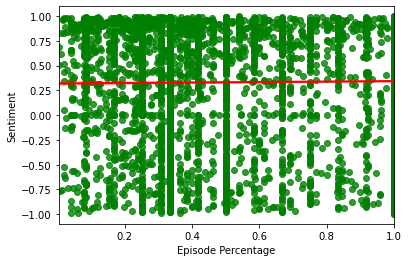

In [370]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=SentAn['Episode Percentage'], y=SentAn['Sentiment'], scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.show()

* Is your sentiment analysis in line with the scores of the animes? 

Extraction of a sample from animeScore:
we are gonna analyze a sample of 12.000 anime (so we are gonna analyze 60.000 rows) and we study the correlation between the Sentiment and the Scores of the anime

In [371]:
scores = df.animeScore[:12000]

In [372]:
scoresSample = []
for i in range(len(scores)):
    for k in range(5):
        scoresSample.append(float(scores[i]))

In [373]:
perc = round(np.corrcoef(scoresSample, sentiments[:60000])[0][1],4)*100
print('Between Sentiment and animeScore there is a correlation of {}%'.format(perc))

Between Sentiment and animeScore there is a correlation of 24.01%


# 5. Algorithmic question

We are asked by a personal trainer who has a back-to-back sequence of requests for appointments, to provide a schedule that maximizes the total length of the accepted appointments avoiding consecutive ones. 

<div>
<img src = "images/images7.png" width = "500px">
</div>

Our first idea is to analyze with a tree all the possible combination of the possible choices. As we can see in the photo below, until we have an array of length 5, the possible choices are forced:

![image4](images/image4.png)

Now that we want to put the fifth element of the array, we can take into account the possibility of appending that directly to the root, that is the first element of the array, but we realize that it makes no sense because:
- time is always positive;
- the fifth element can be appended to the third element since they are not consecutive

so when we want to append the fifth element, since we want to get maximizes the amount of time of the appointment, we put it under the third one.

![image2](images/image2.png)

In conclusion we get a binary tree of the shape:

<div>
<img src = "images/image6.png" width = "500px">
</div>

So in order to solve the problem assigned by the personal trainer we will have to build this type of trees. In particular we note that there are only two possible distinct cases the tree rooted in the first element and the one rooted in the second.\
Pseudocode:

>request = input<br>
<br>
>T1 = **find_index_trees**(length(request))<br>
>**from_index_trees_to_request_item**(T1)<br>
<br>
>T2 = **find_index_trees**(length(request)+1)<br>
>**from_index_trees_to_request_item**(T2)<br>
<br>
>**find_max_sum**(T1,T2)

>define **find_index_trees**(l):<br>
>&emsp;list = [first_el_l]<br>
>&emsp;counter = 2<br>
>&emsp;<br>
>&emsp;while counter < length(l):<br>
>&emsp;&emsp;for each element in list<br>
>&emsp;&emsp;&emsp;if (n-last_value of element == 2) &emsp;&emsp;&emsp;            #we are adding n+1 value to the list<br>
>&emsp;&emsp;&emsp;&emsp;add n to the current element<br>
>&emsp;&emsp;&emsp;if (there is second last value &  n-last_value of element == 3)<br>
>&emsp;&emsp;&emsp;&emsp;aux = copy the list until the second last<br>
>&emsp;&emsp;&emsp;&emsp;if aux is a new element for list<br>
>&emsp;&emsp;&emsp;&emsp;&emsp;add aux to the list<br>
>&emsp;<br>
>&emsp;increase n

>define **from_index_trees_to_request_item**(tree, request)<br>
><br>
>&emsp;for each path in tree<br>
>&emsp;&emsp;turn each value of current path into the correspondent request value

>define **find_max_sum**(tree1, tree2)<br>
><br>
>&emsp;if get_max_value(tree1)>get_max_value(tree2)<br>
>&emsp;&emsp;return the max_valued_list in tree1<br>
>&emsp;else<br>
>&emsp;&emsp;return the max_valued_list in tree2

In [2]:
# we create all the possibile path from 1 to n and we save it in lists
def possiblePath(index):
    lists = [[index[0]]]
    n = 2
    
    while n < len(index):
        for l in lists:
            # we add the element n+1
            if(n - np.where(index == l[-1])[0][0] == 2):
                l.append(index[n])
            # we add the element n+2
            if len(l)>1 and (n - np.where(index == l[-2])[0][0] == 3):
                aux = l[:-1]
                aux.append(index[n]) 
                if aux not in lists:
                    lists.append(aux)
        n +=1
    return lists

In [3]:
# from the path of index obtained in the previous function 
# we  trasform each index in the corrispondent request value
def pathToRequest(path, request):
    
    for l in path:
        for i in range(len(l)):
            ind = l[i]-1
            l[i] = request[ind]
            
    return path

In [4]:
# seraching for the best path between the 1-rooted tree vs the 2-rooted tree
def optimalPath(path1,path2):
    
    sums1 = np.array([sum(l) for l in path1])
    sums2 = np.array([sum(l) for l in path2])
    
    if(max(sums1)>=max(sums2)):
        max_value = np.where(sums1 == max(sums1))[0][0]
        return path1[max_value]
    else:
        max_value = np.where(sums2 == max(sums2))[0][0]
        return path2[max_value]

In [5]:
import numpy as np

request = [30,40,25,50,30,20]
index = np.array([*range(1,len(request)+1)])

path1 = possiblePath(index)
path1 = pathToRequest(path1,request)

path2 = possiblePath(index[1:])
path2 = pathToRequest(path2,request)

request = optimalPath(path1,path2)
print("\nThe best way to accept the appointments in the given order is: ", request ,"\nwith a total duration of :" , sum(request))


The best way to accept the appointments in the given order is:  [40, 50, 20] 
with a total duration of : 110
